In [1]:
#!/usr/bin/python
from __future__ import absolute_import

import numpy as np
from tensorflow import keras
import pickle
import argparse
import copy
import random
import time
import torch

from shapley.apps import Label, Poisoning
from shapley.loader import FashionMnist, MNIST
from shapley.measures import KNN_Shapley, KNN_LOO, G_Shapley, LOO, TMC_Shapley
from shapley.utils.plotter import LabelPlotter, PoisoningPlotter

%matplotlib inline

/home/kahlua/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# standalone experiments

A simple test for the two APIs
``KNN_Shapley._get_shapley_value_torch(self, X_train, y_train, X_test, y_test)`` (torch implementation)
and
``KNN_Shapley._get_shapley_value_np(self, X_train, y_train, X_test, y_test)`` (numpy implementation).

The torch implementation runs faster than the numpy version since the operations are paralleled. If running on cuda, the torch version will be even faster.

In [2]:
measure = KNN_Shapley(K=5)

In [3]:
X_train = torch.randn(1000, 28, 28)
X_test = torch.randn(100, 28, 28)

y_train = torch.LongTensor(1000).random_(0,10)
y_test = torch.LongTensor(100).random_(0,10)

In [4]:
start = time.time()
res1 = measure._get_shapley_value_torch(X_train, y_train, X_test, y_test).numpy()
print(time.time() - start)

0.8419463634490967


In [19]:
X_train_cuda = X_train.cuda()
y_train_cuda = y_train.cuda()
X_test_cuda = X_test.cuda()
y_test_cuda = y_test.cuda()

start = time.time()
res3 = measure._get_shapley_value_torch(X_train_cuda, y_train_cuda, X_test_cuda, y_test_cuda)
print(time.time() - start)

0.360736608505249


In [5]:
start = time.time()
res2 = measure._get_shapley_value_np(X_train, y_train, X_test, y_test)
print(time.time() - start)

6.611276865005493


In [6]:
res1[:20]

array([ 8.5921492e-06, -3.9918883e-05,  5.1855863e-05,  5.1301635e-05,
        1.8364172e-04,  1.3043480e-05,  1.1695117e-05,  9.8459830e-05,
        4.6483437e-05,  6.9547335e-05, -1.2801529e-04,  4.5360634e-05,
        8.7266171e-06,  8.2714035e-04, -9.8430598e-04,  2.5648344e-04,
        8.5209533e-05,  7.1359164e-04, -2.2910869e-04, -2.2110355e-04],
      dtype=float32)

In [7]:
res2[:20]

array([ 8.59191453e-06, -3.99186798e-05,  5.18568110e-05,  5.13025680e-05,
        1.83642666e-04,  1.30434169e-05,  1.16958026e-05,  9.84597379e-05,
        4.64833938e-05,  6.95469458e-05, -1.28014938e-04,  4.54018518e-05,
        8.72677943e-06,  8.27141210e-04, -9.84305976e-04,  2.56483530e-04,
        8.52095189e-05,  7.13591569e-04, -2.29109180e-04, -2.21102736e-04])

# Noisy Label Detection

##### data loading

In [8]:
num = 1000
#loader = MNIST(num_train=num, one_hot=False, shuffle=True, by_label=True)
loader = FashionMnist(num_train=num)
X_data, y_data, X_test_data, y_test_data = loader.prepare_data()

###### measure

In [9]:
measure_KNN = KNN_Shapley(K=5)
measure_KNNLOO = KNN_LOO(K=5)
# measure = G_Shapley()
# measure = TMC_Shapley()
# measure = LOO()

##### application

In [10]:
app = Label(X_data, y_data, X_test_data, y_test_data, model_family='NN')

##### run

In [11]:
res_knn = app.run(measure_KNN)
res_knnloo = app.run(measure_KNNLOO)

done!
result shown below:
[ 1.47088272e-03  1.85998039e-03  2.82120199e-04  2.11732010e-03
  1.11684946e-03  1.19685357e-03  1.01171702e-03  1.07641815e-03
  3.37684189e-04  2.31083415e-03 -6.60825993e-04  9.98359683e-04
  5.13839593e-04  3.03610759e-03  7.53471875e-05  2.29314547e-03
  2.62229510e-03  1.55250006e-03  1.24900285e-03  1.94725527e-03
  1.37508655e-03  1.11935459e-03  1.22909831e-03  9.22130296e-04
  1.59981058e-03  1.36609823e-03  4.64774135e-04 -3.49651990e-03
  9.21566361e-04  1.25358320e-03  1.20680261e-03  9.08980616e-04
  1.28641113e-03  1.20130404e-03  1.00483719e-03  1.54003689e-03
  7.65366255e-04  1.07511549e-03  2.00532665e-03 -7.23948122e-04
  1.35134408e-03  4.72063149e-04  2.36853303e-03  1.10146250e-03
  1.31362806e-03  2.35503878e-03  2.14349070e-03  1.75727447e-03
  1.10504534e-03  8.60134550e-04  8.24159858e-04  9.89686182e-04
 -6.74467957e-04 -3.61540121e-03  1.42845548e-03  1.00883014e-03
  9.35231885e-04  1.35500992e-03 -2.12711390e-03  1.32252902e-03

done!
result shown below:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. 

##### visualize

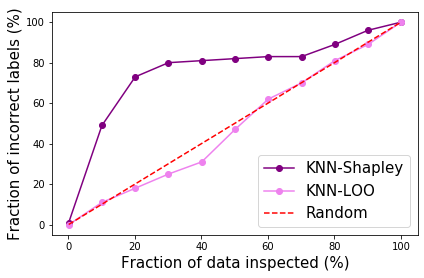

In [12]:
LabelPlotter(app, ('KNN-Shapley',res_knn), ('KNN-LOO',res_knnloo)).plot()

# Pattern-based Watermark Removal

##### data loading

In [13]:
num = 1000
loader = FashionMnist(num_train=num)
X_data, y_data, X_test_data, y_test_data = loader.prepare_data()

###### measure

In [14]:
measure_KNN = KNN_Shapley(K=5)
measure_KNNLOO = KNN_LOO(K=5)

##### application

In [15]:
app = Poisoning(X_data, y_data, X_test_data, y_test_data, model_family='NN')

##### run

In [16]:
res_knn = app.run(measure_KNN)
res_knnloo = app.run(measure_KNNLOO)

done!
result shown below:
[ 1.25604991e-03  7.83126430e-04  9.78047086e-04  1.26617179e-03
  9.66920921e-04  8.91731924e-04  1.47889962e-03 -6.39097020e-04
  4.50567059e-04  7.34051368e-04 -3.33872223e-03  1.19814246e-03
  8.99142777e-04  1.00393708e-03  1.05035730e-03  5.30428701e-04
  9.45583452e-04  2.31773621e-03  1.05145953e-03  6.28271646e-04
  8.82734144e-04  8.79215583e-04  1.34404778e-03  9.39648190e-04
 -1.41505157e-03  5.14078115e-04  1.32077900e-03  9.71016663e-04
  8.72933342e-04  8.83278736e-04  7.70806646e-04  8.01139396e-04
 -1.28818064e-03  9.03143500e-04  1.74837104e-03  2.16653893e-04
 -2.33804658e-04  1.43653831e-03  1.11329559e-04  1.32037592e-03
 -9.49748056e-04 -2.18936602e-03  2.53239471e-03  2.04080810e-03
  2.56731737e-04  9.10951338e-04  3.38542239e-04  2.49614090e-03
  9.75335961e-04  1.59423221e-03  1.22220623e-03  1.16776129e-03
  1.15761997e-03  1.32686492e-03 -6.29773361e-04  1.46486964e-03
  1.64164078e-04 -1.83677605e-03  1.66719672e-03  9.45352639e-04

done!
result shown below:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. 

##### visualize

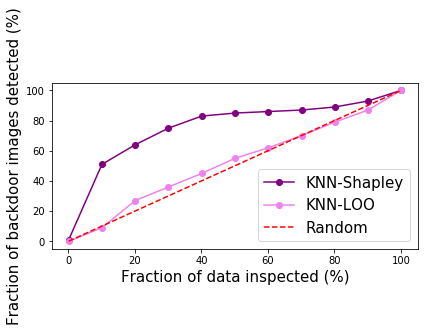

In [17]:
PoisoningPlotter(app, ('KNN-Shapley',res_knn), ('KNN-LOO',res_knnloo)).plot()

# Instance-based Watermark Removal

##### data loading

In [ ]:
# load MNIST

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # instance-based watermark removal

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Data Summarization

##### data loading

In [ ]:
# load UCI Adult dataset

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # data summarization

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Data Acquisition

##### data loading

In [ ]:
# load MNIST

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # data acquisition

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Domain Adapatation

##### data loading

In [ ]:
# load two datasets

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # domain adaptation

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED